In [1]:
%matplotlib inline

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.neighbors import NearestNeighbors

from quickda.explore_data import *
from quickda.clean_data import *
from quickda.explore_numeric import *
from quickda.explore_categoric import *
from quickda.explore_numeric_categoric import *
from quickda.explore_time_series import *

from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer

sns.set_style('whitegrid')
sns.set_context('notebook')

import warnings
warnings.filterwarnings('ignore')


In [2]:
def percentual_outlier(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    minimum = Q1 - (1.5 * IQR)
    maximum = Q3 + (1.5 * IQR)
    num_outliers =  np.sum((data < minimum) | (data > maximum))
    num_total = data.count()
    return (num_outliers/num_total)*100

def calculate_wcss(data, num):
        wcss = []
        for n in range(2, num):
            kmeans = KMeans(n_clusters=n)
            kmeans.fit(X=data)
            wcss.append(kmeans.inertia_)
    
        return wcss
    
def calculate_silhouete(data, num):
        silhouete_avg = []
        for n in range(2, num):
            kmeans = KMeans(n_clusters=n)
            kmeans.fit(X=data)
            cluster_labels = kmeans.labels_
            silhouete_avg.append(silhouette_score(data, cluster_labels))
    
        return silhouete_avg

def spider_plot(data, cluster):
    means = data.groupby('kmeans').mean().to_numpy()
    names = data.columns[0:-1]
    label_loc = np.linspace(start=0, stop=1 * np.pi, num=len(names))
    categories = np.arange(0, len(means))
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(projection="polar")
    #for i in range(len(means)):
    ax.plot(label_loc, means[cluster], label=f'class {categories[cluster]}')
    ax.set_title(f'Cluster {cluster}', size=20)
    lines, labels = plt.thetagrids(np.degrees(label_loc), labels=names)
    #plt.legend(loc="lower left")
    plt.show()

## Carregando os Dados

In [3]:
df = pd.read_csv("./dados_cluster.csv")

In [4]:
explore(df)

dtypes  count  null_sum  null_pct  nunique  \
anoFundacao                  float64   6012         0     0.000       64   
ativoCirculante              float64   6012         0     0.000     1794   
capitalSocial                float64   6012         0     0.000      296   
cnpjSemTraco                  object   6012         0     0.000     1523   
custos                       float64   6010         2     0.000     1690   
dashboardCorrelacao          float64   6012         0     0.000      519   
dataAprovadoEmComite          object    443      5569     0.926      443   
dataAprovadoNivelAnalista     object   4652      1360     0.226     4652   
definicaoRisco                object   6012         0     0.000        4   
diferencaPercentualRisco     float64   6012         0     0.000       77   
duplicatasAReceber           float64   6012         0     0.000     1668   
empresa_MeEppMei                bool   6012         0     0.000        2   
endividamento                float64   6012         0     0.000     1185   
estoque                      float64   6012         0     0.000     1674   
faturamentoBruto             float64   6010         2     0.000     2231   
intervaloFundacao             object   6012         0     0.000        4   
limiteEmpresaAnaliseCredito  float64   6012         0     0.000     1378   
maiorAtraso                    int64   6012         0     0.000      153   
margemBruta                  float64   6010         2     0.000     1831   
margemBrutaAcumulada         float64   6012         0     0.000     1200   
nomeFantasia                  object   6012         0     0.000     1470   
numero_solicitacao             int64   6012         0     0.000     6012   
passivoCirculante            float64   6012         0     0.000     1789   
percentualProtestos          float64   5047       965     0.161        2   
percentualRisco              float64   6012         0     0.000       79   
periodoBalanco                object   6012         0     0.000      124   
periodoDemonstrativoEmMeses  float64   6010         2     0.000       12   
prazoMedioRecebimentoVendas    int64   6012         0     0.000      149   
primeiraCompra                object   5945        67     0.011     1206   
razaoSocial                   object   6012         0     0.000     1490   
restricoes                      bool   6012         0     0.000        2   
scorePontualidade            float64   6012         0     0.000      285   
status                        object   6012         0     0.000        7   
titulosEmAberto              float64   6012         0     0.000      563   
totalAtivo                   float64   6012         0     0.000     1788   
totalPatrimonioLiquido       float64   6012         0     0.000     1759   
valorAprovado                float64   5095       917     0.153      287   
valorSolicitado              float64   6012         0     0.000      318   

                                                   min        25%        50%  \
anoFundacao                                     1000.0     2000.0     2009.0   
ativoCirculante                                  -17.0   529853.0  3230248.0   
capitalSocial                                      0.0    95400.0   200000.0   
cnpjSemTraco                        AADG56617962174727          -          -   
custos                                    -346633805.0        0.0  2171507.0   
dashboardCorrelacao                           -0.99999        0.0        0.0   
dataAprovadoEmComite                                 -          -          -   
dataAprovadoNivelAnalista                            -          -          -   
definicaoRisco               De 0 a 10 % - Muito Baixo          -          -   
diferencaPercentualRisco                      0.207547   0.679245   0.785714   
duplicatasAReceber                         -22780710.0        0.0   878819.0   
empresa_MeEppMei                                 False        0.0        0.0   
endividamento            

## Retirando cnpjs duplicados

In [5]:
df.drop_duplicates(subset='cnpjSemTraco', keep='last', inplace=True)

## Retirando as colunas que não iremos usar na análise de clusters

In [6]:
df.drop(['valorAprovado', 'dataAprovadoEmComite', 'dataAprovadoNivelAnalista', 'percentualProtestos', 'numero_solicitacao', 
         'razaoSocial', 'nomeFantasia', 'anoFundacao', 'status', 'definicaoRisco', 'diferencaPercentualRisco', 'dashboardCorrelacao', 
         'periodoBalanco', 'primeiraCompra', 'intervaloFundacao', 'periodoDemonstrativoEmMeses', 'cnpjSemTraco'], axis=1, inplace=True)

## Transformando as variáveis booleanas em númericas. 

In [7]:
df.restricoes = df.restricoes.apply(lambda x:1 if x else 0)
df.empresa_MeEppMei = df.empresa_MeEppMei.apply(lambda x:1 if x else 0)

In [8]:
explore(df)

dtypes  count  null_sum  null_pct  nunique  \
maiorAtraso                    int64   1523         0       0.0      153   
margemBrutaAcumulada         float64   1523         0       0.0     1200   
prazoMedioRecebimentoVendas    int64   1523         0       0.0      149   
titulosEmAberto              float64   1523         0       0.0      563   
valorSolicitado              float64   1523         0       0.0      159   
percentualRisco              float64   1523         0       0.0       63   
ativoCirculante              float64   1523         0       0.0     1178   
passivoCirculante            float64   1523         0       0.0     1168   
totalAtivo                   float64   1523         0       0.0     1180   
totalPatrimonioLiquido       float64   1523         0       0.0     1166   
endividamento                float64   1523         0       0.0      636   
duplicatasAReceber           float64   1523         0       0.0     1042   
estoque                      float64   1523         0       0.0     1105   
faturamentoBruto             float64   1523         0       0.0     1415   
margemBruta                  float64   1523         0       0.0     1068   
custos                       float64   1523         0       0.0     1033   
capitalSocial                float64   1523         0       0.0      284   
restricoes                     int64   1523         0       0.0        2   
empresa_MeEppMei               int64   1523         0       0.0        2   
scorePontualidade            float64   1523         0       0.0      285   
limiteEmpresaAnaliseCredito  float64   1523         0       0.0      861   

                                     min          25%          50%  \
maiorAtraso                          0.0        0.000        5.000   
margemBrutaAcumulada                 0.0        0.220        0.387   
prazoMedioRecebimentoVendas          0.0        0.000        0.000   
titulosEmAberto                      0.0        0.000        0.000   
valorSolicitado                    100.0    30000.000    60000.000   
percentualRisco                      0.0        0.143        0.214   
ativoCirculante                      0.0   298293.000  2451304.000   
passivoCirculante             -1134941.0    44519.500   779307.000   
totalAtivo                           0.0   364756.000  2846875.000   
totalPatrimonioLiquido      -186719734.0    49100.500  1101916.000   
endividamento                        0.0        0.000        0.000   
duplicatasAReceber           -22780710.0        0.000   567455.000   
estoque                              0.0     8667.500   605595.000   
faturamentoBruto                     0.0  1672928.500  4925896.000   
margemBruta                 -614872100.0        0.000  1364721.000   
custos                         -431401.0        0.000  1565850.000   
capitalSocial                        0.0    80000.000   150000.000   
restricoes                           0.0        0.000        0.000   
empresa_MeEppMei                     0.0        0.000        0.000   
scorePontualidade                    0.0        0.792        1.000   
limiteEmpresaAnaliseCredito          0.0     9900.000    72600.000   

                                      75%           max          mean  \
maiorAtraso                  2.000000e+01  9.770000e+02  2.312500e+01   
margemBrutaAcumulada         4.950000e-01  1.000000e+00  3.400000e-01   
prazoMedioRecebimentoVendas  2.100000e+01  1.605000e+03  2.012000e+01   
titulosEmAberto              9.940000e+03  2.836656e+06  4.092816e+04   
valorSolicitado              1.635000e+05  6.000000e+08  6.168863e+05   
percentualRisco              3.040000e-01  6.610000e-01  2.220000e-01   
ativoCirculante              1.134704e+07  2.903832e+10  5.391843e+07   
passivoCirculante            4.808169e+06  2.750382e+10  4.559232e+07   
totalAtivo                   1.291962e+07  5.482350e+10  9.602702e+07   
totalPatrimonioLiquido       5.735235e+06  1.292328e+10  3.247566e+07   
endividamento

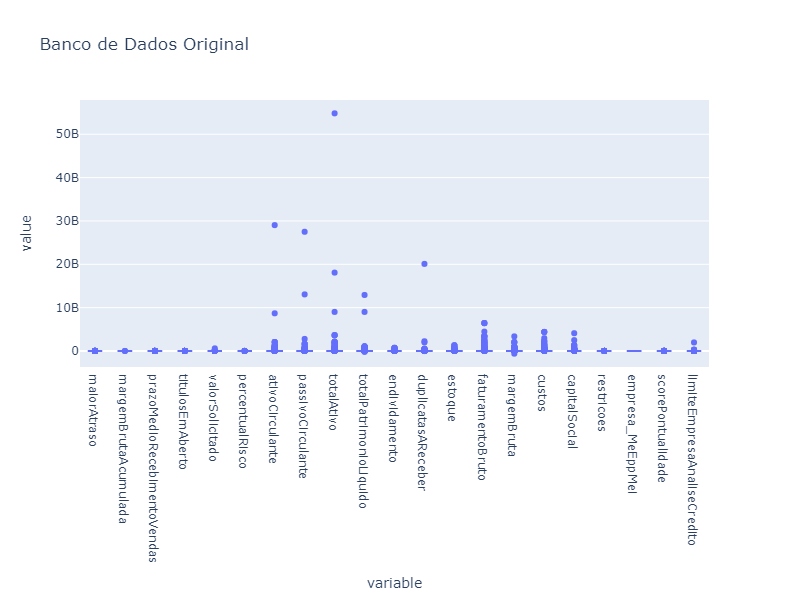

In [9]:
fig = px.box(data_frame = df, height=600, title='Banco de Dados Original')
fig.show()

## Como podemos ver no Boxplot acima temos diversos valores outliers. Como iremos fazer uma análise de clusterização que leva em conta as distancias entre os dados estes outliers podem atrapalhar o resultado final, pois no gráfico nem é possível ver o boxplot corretamente.<BR>
## Para visualizarmos melhor vamos calcular o percentual de dados acima e abaixo dos limites inferior e superior, respctivamente, do gráfico boxplot.

In [10]:
for coluna in df.columns:
    data = df[coluna]
    perc = str(round(percentual_outlier(data), 2))
    print(f'Outliers na coluna {coluna} : {perc}%')

Outliers na coluna maiorAtraso : 11.1%
Outliers na coluna margemBrutaAcumulada : 0.13%
Outliers na coluna prazoMedioRecebimentoVendas : 10.7%
Outliers na coluna titulosEmAberto : 17.07%
Outliers na coluna valorSolicitado : 13.46%
Outliers na coluna percentualRisco : 1.12%
Outliers na coluna ativoCirculante : 13.0%
Outliers na coluna passivoCirculante : 13.92%
Outliers na coluna totalAtivo : 13.72%
Outliers na coluna totalPatrimonioLiquido : 13.99%
Outliers na coluna endividamento : 18.25%
Outliers na coluna duplicatasAReceber : 14.71%
Outliers na coluna estoque : 13.13%
Outliers na coluna faturamentoBruto : 14.31%
Outliers na coluna margemBruta : 13.53%
Outliers na coluna custos : 15.5%
Outliers na coluna capitalSocial : 15.56%
Outliers na coluna restricoes : 9.85%
Outliers na coluna empresa_MeEppMei : 0.0%
Outliers na coluna scorePontualidade : 22.13%
Outliers na coluna limiteEmpresaAnaliseCredito : 16.74%


In [11]:
mmsc = MinMaxScaler().fit(df)
df_mmsc = pd.DataFrame(mmsc.transform(df), columns=df.columns)
explore(df_mmsc)

dtypes  count  null_sum  null_pct  nunique  min  \
maiorAtraso                  float64   1523         0       0.0      153  0.0   
margemBrutaAcumulada         float64   1523         0       0.0     1200  0.0   
prazoMedioRecebimentoVendas  float64   1523         0       0.0      149  0.0   
titulosEmAberto              float64   1523         0       0.0      563  0.0   
valorSolicitado              float64   1523         0       0.0      159  0.0   
percentualRisco              float64   1523         0       0.0       63  0.0   
ativoCirculante              float64   1523         0       0.0     1178  0.0   
passivoCirculante            float64   1523         0       0.0     1168  0.0   
totalAtivo                   float64   1523         0       0.0     1180  0.0   
totalPatrimonioLiquido       float64   1523         0       0.0     1166  0.0   
endividamento                float64   1523         0       0.0      636  0.0   
duplicatasAReceber           float64   1523         0       0.0     1042  0.0   
estoque                      float64   1523         0       0.0     1105  0.0   
faturamentoBruto             float64   1523         0       0.0     1415  0.0   
margemBruta                  float64   1523         0       0.0     1068  0.0   
custos                       float64   1523         0       0.0     1033  0.0   
capitalSocial                float64   1523         0       0.0      284  0.0   
restricoes                   float64   1523         0       0.0        2  0.0   
empresa_MeEppMei             float64   1523         0       0.0        2  0.0   
scorePontualidade            float64   1523         0       0.0      285  0.0   
limiteEmpresaAnaliseCredito  float64   1523         0       0.0      861  0.0   

                               25%    50%    75%  max   mean  median    std  \
maiorAtraso                  0.000  0.005  0.020  1.0  0.024   0.005  0.062   
margemBrutaAcumulada         0.220  0.387  0.495  1.0  0.340   0.387  0.211   
prazoMedioRecebimentoVendas  0.000  0.000  0.013  1.0  0.013   0.000  0.039   
titulosEmAberto              0.000  0.000  0.004  1.0  0.014   0.000  0.062   
valorSolicitado              0.000  0.000  0.000  1.0  0.001   0.000  0.026   
percentualRisco              0.216  0.324  0.459  1.0  0.337   0.324  0.180   
ativoCirculante              0.000  0.000  0.000  1.0  0.002   0.000  0.027   
passivoCirculante            0.000  0.000  0.000  1.0  0.002   0.000  0.029   
totalAtivo                   0.000  0.000  0.000  1.0  0.002   0.000  0.028   
totalPatrimonioLiquido       0.014  0.014  0.015  1.0  0.017   0.014  0.031   
endividamento                0.000  0.000  0.001  1.0  0.007   0.000  0.056   
duplicatasAReceber           0.001  0.001  0.001  1.0  0.002   0.001  0.026   
estoque                      0.000  0.000  0.003  1.0  0.010   0.000  0.059   
faturamentoBruto             0.000  0.001  0.003  1.0  0.012   0.001  0.064   
margemBruta                  0.154  0.155  0.156  1.0  0.161   0.155  0.038   
custos                       0.000  0.000  0.002  1.0  0.010   0.000  0.059   
capitalSocial                0.000  0.000  0.000  1.0  0.004   0.000  0.036   
restricoes                   0.000  0.000  0.000  1.0  0.098   0.000  0.298   
empresa_MeEppMei             0.000  0.000  1.000  1.0  0.317   0.000  0.466   
scorePontualidade            0.792  1.000  1.000  1.0  0.764   1.000  0.405   
limiteEmpresaAnaliseCredito  0.000  0.000  0.000  1.0  0.002   0.000  0.027   

                               skew  
maiorAtraso                   7.657  
margemBrutaAcumulada         -0.448  
prazoMedioRecebimentoVendas  12.886  
titulosEmAberto               8.188  
valorSolicitado              38.957  
percentualRisco               0.635  
ativoCirculante              33.697  
passivoCirculante            30.801  
totalAtivo                   32.449  
totalPatrimonioLiquido       26.956  
endividamento                14.833  
duplicatasAReceber           37.596  
estoque       

# PCA

In [12]:
pca = PCA(n_components=0.95, svd_solver='full', random_state=42)
pca.fit(df_mmsc)
PCA_labels = ['PC'+str(x) for x in range(1,len(pca.components_)+1)]
df_pca = pd.DataFrame(pca.transform(df_mmsc), columns=PCA_labels)
df_pca

PC1       PC2       PC3       PC4       PC5       PC6
0     0.556825  0.920021 -0.161342 -0.026589  0.013239 -0.025657
1     0.723119 -0.128326 -0.023003 -0.033576 -0.045893  0.014520
2     0.567168  0.923014 -0.149472  0.028734  0.011284 -0.023482
3     0.577546  0.926053 -0.137633  0.083739  0.009367 -0.020763
4     0.723067 -0.126966 -0.023238 -0.033473 -0.047746  0.014262
...        ...       ...       ...       ...       ...       ...
1518 -0.244256 -0.348016 -0.058501  0.123137  0.076642  0.019149
1519 -0.306788 -0.142720 -0.123528 -0.032639  0.003608 -0.012059
1520  0.723101 -0.159037 -0.022659 -0.053115  0.022426  0.011605
1521 -0.282902 -0.321183 -0.093104 -0.035862 -0.008563  0.033805
1522 -0.280647 -0.341504 -0.102548 -0.058024  0.039393 -0.009410

[1523 rows x 6 columns]

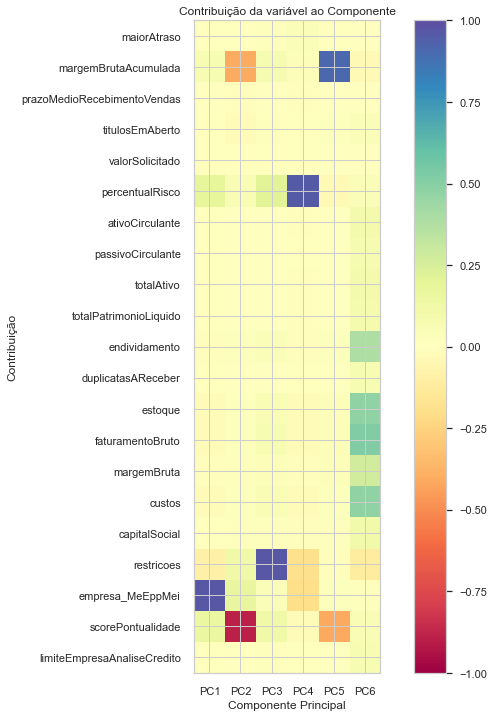

In [13]:
fig, ax = plt.subplots(figsize=(12, 12))
plt.imshow(pca.components_.T, cmap="Spectral", vmin=-1, vmax=1)
plt.yticks(range(len(df_mmsc.columns)), df_mmsc.columns)
plt.xticks(range(len(df_pca.columns)), df_pca.columns)
plt.xlabel("Componente Principal")
plt.ylabel("Contribuição")
plt.title("Contribuição da variável ao Componente")
plt.colorbar()

## Definindo valores para KMeans DBScan

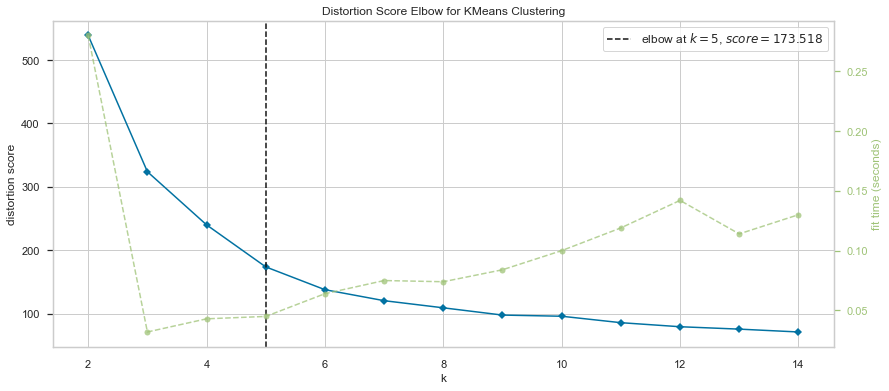

In [14]:
fig = plt.figure(figsize=(14,6))

model = KMeans(random_state=42)
distortion_visualizer = KElbowVisualizer(model, k=(2,15))

distortion_visualizer.fit(df_mmsc)       
distortion_visualizer.show()
plt.show()

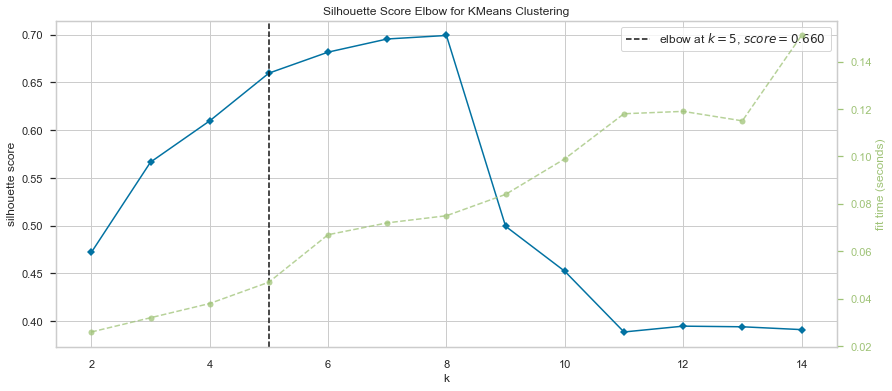

In [15]:
fig = plt.figure(figsize=(14,6))

model = KMeans(random_state=42)
distortion_visualizer = KElbowVisualizer(model, metric='silhouette',k=(2,15))

distortion_visualizer.fit(df_mmsc)       
distortion_visualizer.show()
plt.show()

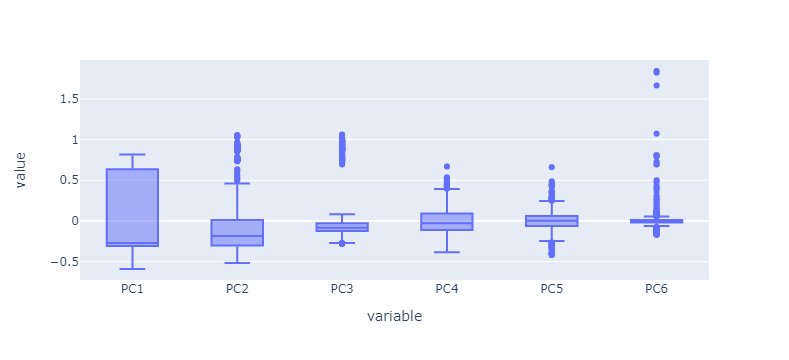

In [16]:
fig = px.box(df_pca)
fig.show()

## Gerando Clusters

In [18]:
km = KMeans(n_clusters=5, n_init=100)
km_labels = km.fit_predict(df_pca)

In [19]:
df_mmsc['kmeans'] = km_labels
df_pca['kmeans'] = km_labels
df['kmeans'] = km_labels

In [20]:
df.groupby('kmeans').ativoCirculante.count()

kmeans
0    383
1    728
2    190
3    100
4    122
Name: ativoCirculante, dtype: int64

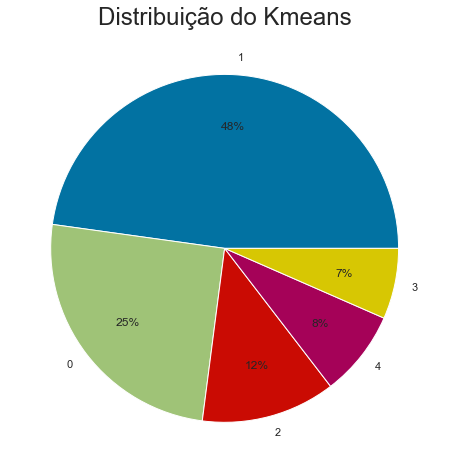

In [21]:
fig = plt.figure(figsize=(8,8))
df_pca.kmeans.value_counts().plot.pie(autopct='%1.0f%%', pctdistance=0.7, labeldistance=1.1)
plt.title('Distribuição do Kmeans', size=24)
plt.ylabel("")
plt.show()

In [25]:
with pd.ExcelWriter("df_excel.xlsx") as writer:
    df.to_excel(writer)

# Avaliação do Modelo

Vamos usar duas métricas para avaliar o modelo, e depois analisar algugns gráficos

The Davis-Bouldin Index is the average similarity between each cluster and the closest cluster. Scores range from 0 and up. 0 indicates better clustering.
The Silhouette Coefficient is a value between -1 and 1. The higher the score, the better. 1 indicates tight clusters, and 0 means overlapping clusters.

In [22]:
print(f'Davies-Bouldin index = {davies_bouldin_score(df_pca, km_labels)}')
print(f'Silhouette Score = {silhouette_score(df_pca, km_labels)}')

Davies-Bouldin index = 0.3734712972927533
Silhouette Score = 0.7832462276475257


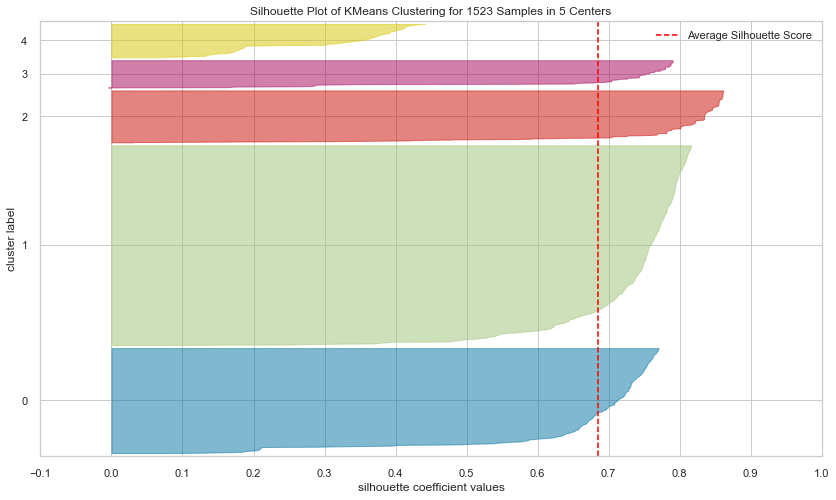

In [23]:
fig = plt.figure(figsize=(14,8))

visualizer = SilhouetteVisualizer(km, colors='yellowbrick')
visualizer.fit(df_pca.drop(['kmeans'],axis=1))
visualizer.show()
plt.show()

In [40]:
def spider_plot(data, cluster):
    means = data.groupby('kmeans').mean().to_numpy()
    names = data.columns[0:-1]
    label_loc = np.linspace(start=0, stop=1.8 * np.pi, num=len(names))
    categories = np.arange(0, len(means))
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(projection="polar")
    #for i in range(len(means)):
    ax.plot(label_loc, means[cluster], label=f'class {categories[cluster]}')
    ax.set_title(f'Cluster {cluster}', size=20)
    lines, labels = plt.thetagrids(np.degrees(label_loc), labels=names)
    #plt.legend(loc="lower left")
    plt.show()

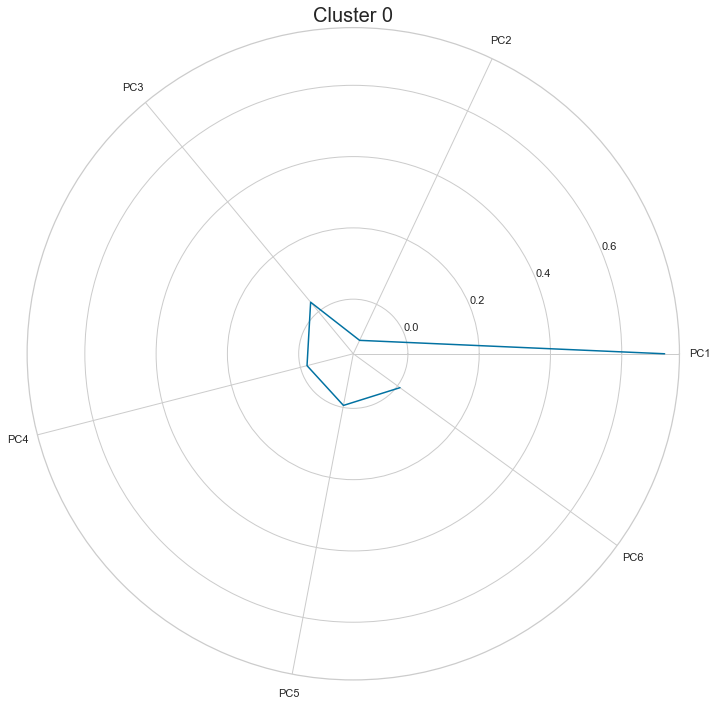

In [41]:
spider_plot(df_pca, 0)

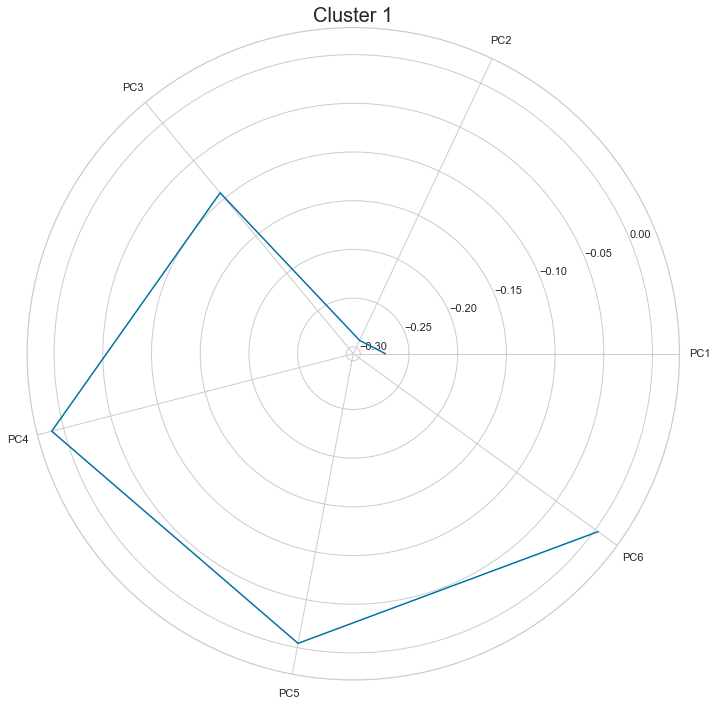

In [42]:
spider_plot(df_pca, 1)

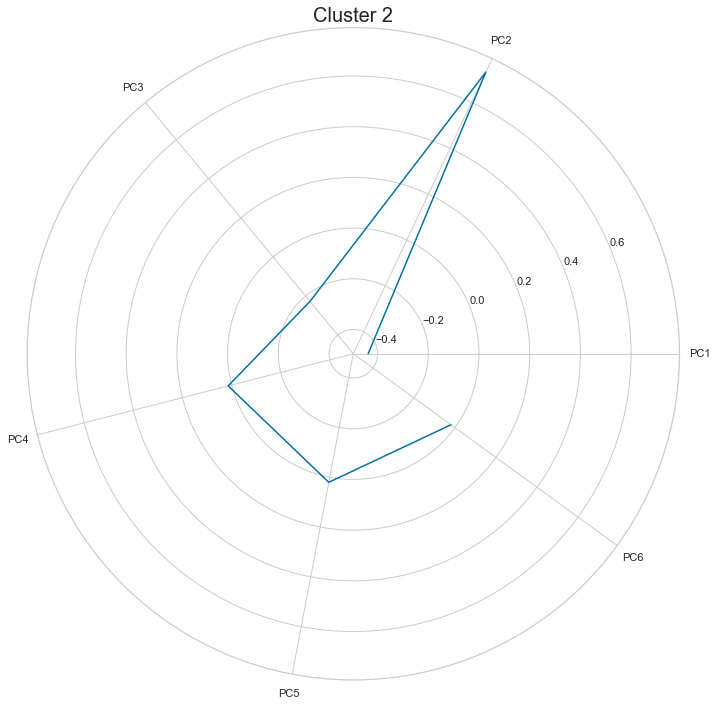

In [43]:
spider_plot(df_pca, 2)

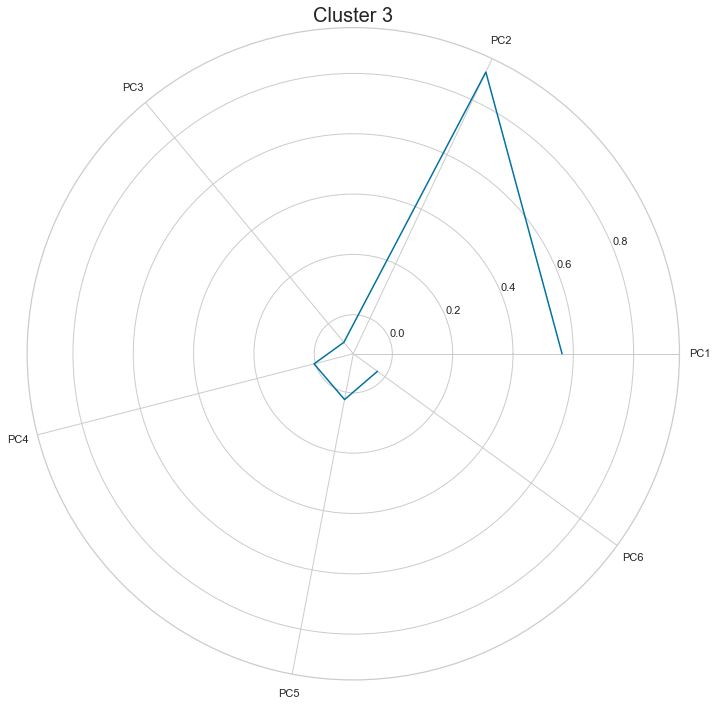

In [44]:
spider_plot(df_pca, 3)

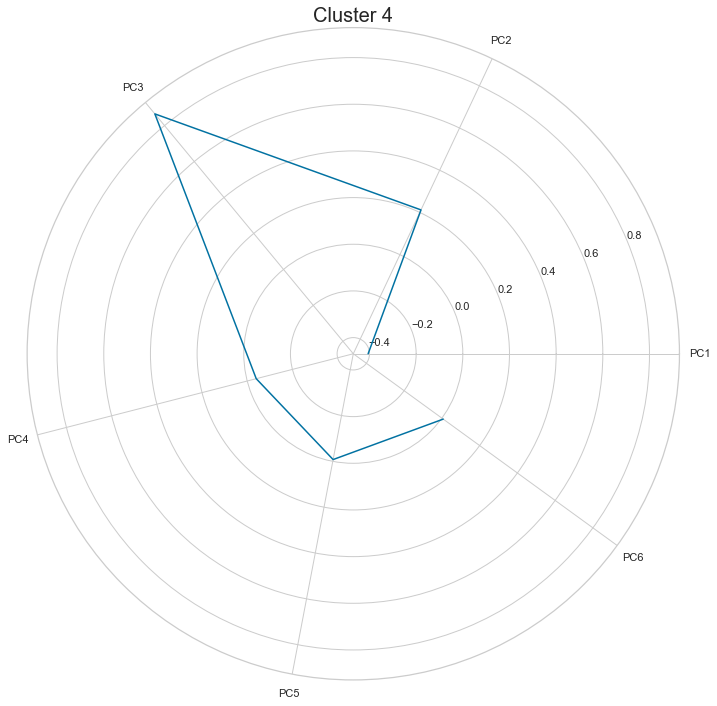

In [45]:
spider_plot(df_pca, 4)

In [46]:
df_novo = df[['margemBrutaAcumulada', 'percentualRisco', 'restricoes', 'empresa_MeEppMei', 'scorePontualidade', 'endividamento', 'estoque', 'faturamentoBruto', 'custos', 'kmeans']]

In [47]:
with pd.ExcelWriter("df_novo.xlsx") as writer:
    df_novo.to_excel(writer)

## Novas classificações

In [48]:
explore(df_novo)

dtypes  count  null_sum  null_pct  nunique       min  \
margemBrutaAcumulada  float64   1523         0       0.0     1200       0.0   
percentualRisco       float64   1523         0       0.0       63       0.0   
restricoes              int64   1523         0       0.0        2       0.0   
empresa_MeEppMei        int64   1523         0       0.0        2       0.0   
scorePontualidade     float64   1523         0       0.0      285       0.0   
endividamento         float64   1523         0       0.0      636       0.0   
estoque               float64   1523         0       0.0     1105       0.0   
faturamentoBruto      float64   1523         0       0.0     1415       0.0   
custos                float64   1523         0       0.0     1033 -431401.0   
kmeans                  int32   1523         0       0.0        5       0.0   

                              25%          50%           75%           max  \
margemBrutaAcumulada        0.220        0.387  4.950000e-01  1.000000e+00   
percentualRisco             0.143        0.214  3.040000e-01  6.610000e-01   
restricoes                  0.000        0.000  0.000000e+00  1.000000e+00   
empresa_MeEppMei            0.000        0.000  1.000000e+00  1.000000e+00   
scorePontualidade           0.792        1.000  1.000000e+00  1.000000e+00   
endividamento               0.000        0.000  4.102690e+05  7.406315e+08   
estoque                  8667.500   605595.000  3.524299e+06  1.293428e+09   
faturamentoBruto      1672928.500  4925896.000  2.146639e+07  6.426115e+09   
custos                      0.000  1565850.000  8.736359e+06  4.393536e+09   
kmeans                      0.000        1.000  2.000000e+00  4.000000e+00   

                              mean       median           std    skew  
margemBrutaAcumulada  3.400000e-01        0.387  2.110000e-01  -0.448  
percentualRisco       2.220000e-01        0.214  1.190000e-01   0.635  
restricoes            9.800000e-02        0.000  2.980000e-01   2.698  
empresa_MeEppMei      3.170000e-01        0.000  4.660000e-01   0.787  
scorePontualidade     7.640000e-01        1.000  4.050000e-01  -1.290  
endividamento         4.856513e+06        0.000  4.170180e+07  14.833  
estoque               1.240604e+07   605595.000  7.614312e+07  12.385  
faturamentoBruto      7.564411e+07  4925896.000  4.089853e+08  10.747  
custos                4.190715e+07  1565850.000  2.599065e+08  12.264  
kmeans                1.245000e+00        1.000  1.140000e+00   1.075

In [58]:
from sklearn import tree
import graphviz

In [61]:
Y = df_novo[['kmeans']]
X = df_novo.drop(['kmeans'],axis=1)

In [62]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, Y)

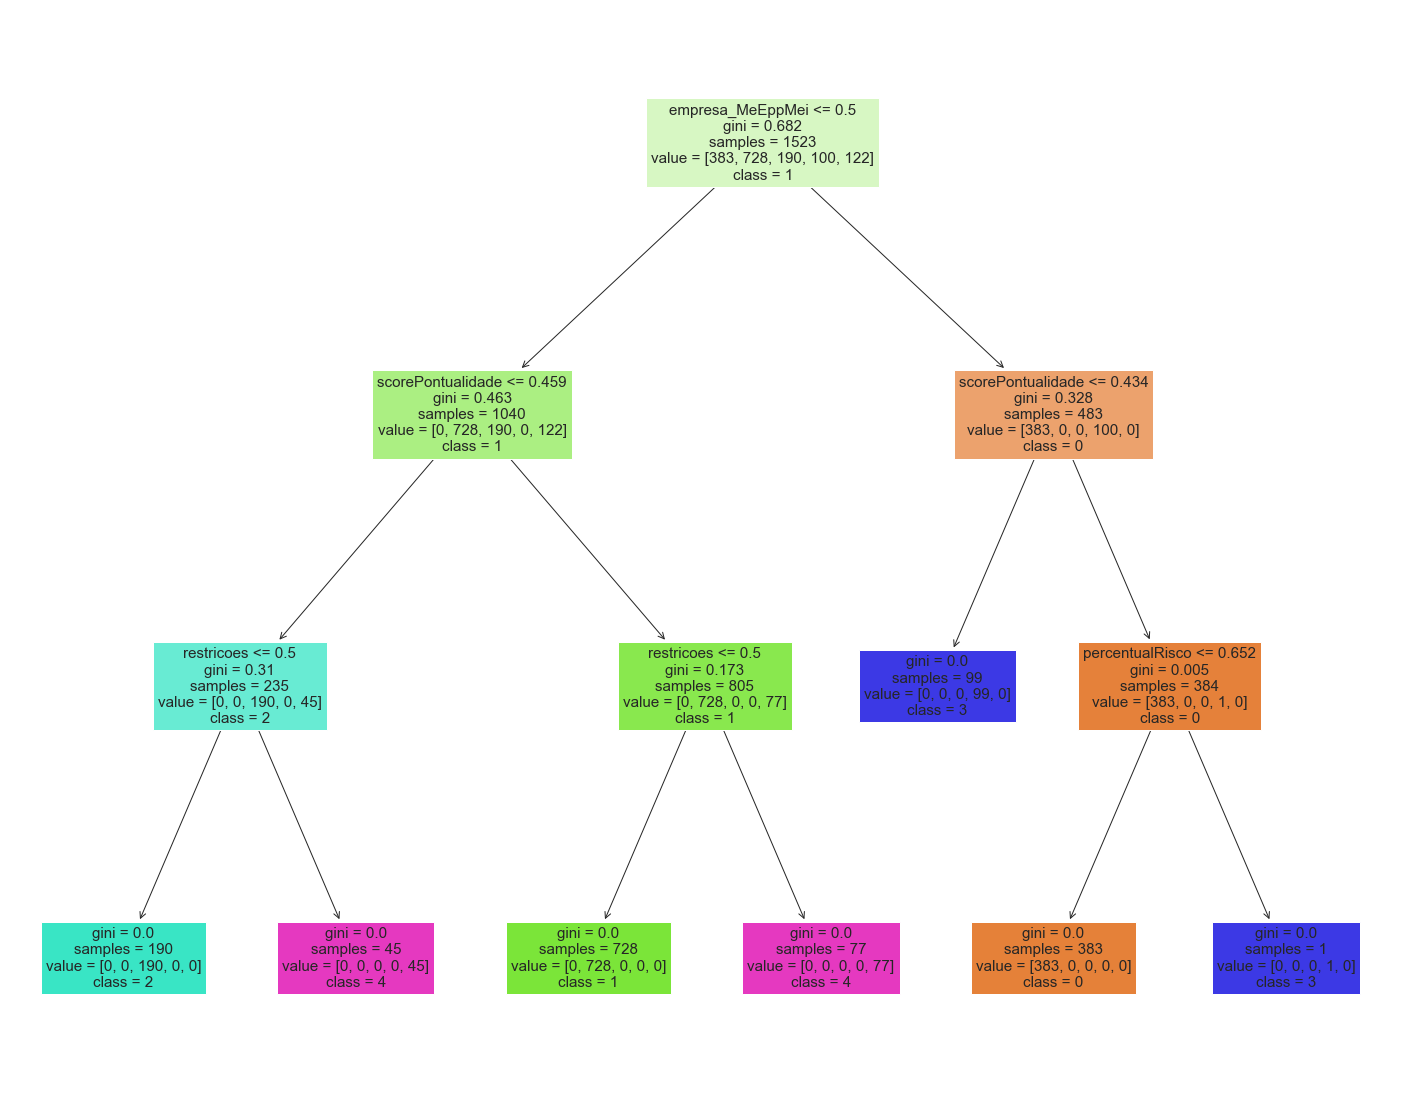

In [65]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf, 
                   feature_names=X.columns,  
                   class_names=['0', '1', '2', '3', '4'],
                   filled=True)

In [ ]:
fig.savefig("decistion_tree.png")